In [ ]:
import nd2reader
import pandas as pd
import string
import numpy as np
from scipy import stats
import os
from multiprocessing import Pool
from os.path import splitext,basename
import cv2
from skimage.segmentation import random_walker
# from skimage.data import binary_blobs
from skimage import io,exposure,restoration,filters,morphology,measure
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [ ]:
def nd2arr_list(nd_dh,nd_fns):
    arr_list=[]
    for nd_fn in nd_fns:
        nd = nd2reader.Nd2("%s/%s" % (nd_dh,nd_fn))
        for ndi in nd:
            arr_list.append(np.array(ndi))
        del nd
    return arr_list

def nd2vid(nd_fns,nd_dh):
    def arr_list2vid(arr_list,vid_fh):
        dpi = 100
        xpixels, ypixels = 512, 512
        fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
        ax = plt.Axes(fig, [0., 0., 1, 1])
        fig.add_axes(ax)
        ax.set_axis_off()
        ax.set_aspect('equal')
        im = ax.imshow(arr_list[0],cmap='gray')
        # plt.savefig('test.png')
        def update_img(n):
            tmp = arr_list[n]
            im.set_data(tmp)
            return im
        # #legend(loc=0)
        ani = animation.FuncAnimation(fig,update_img,np.arange(1,len(arr_list)),interval=60,blit=False)
        writer = animation.writers['ffmpeg'](fps=4)
        ani.save(vid_fh,writer=writer)#dpi=dpi
    arr_list=nd2arr_list(nd_dh,nd_fns)
    arr_list2vid(arr_list,fh_xls+'.mp4')
    
def nd2kins(nd_fns,nd_dh):
    def raw2phasecorr(arr_list):
        cx = 0.0
        cy = 0.0
        stb_arr_list=[]
        prev_image = np.float32(arr_list[0]) #ref
        for frame in arr_list:
            image = np.float32(frame)
            # TODO: set window around phase correlation
            dp = cv2.phaseCorrelate(prev_image, image)
            cx = cx - dp[0]
            cy = cy - dp[1]
            xform = np.float32([[1, 0, cx], [0, 1, cy]])
            stable_image = cv2.warpAffine(image, xform, dsize=(image.shape[1], image.shape[0]))
            prev_image = image
            #clip sides
            ht,wd=np.shape(stable_image)
            clip=0.25
            lt=int(wd*clip)
            rt=int(wd-wd*clip)
            up=int(ht*clip)
            dw=int(ht-ht*clip)
            stable_image_clipped=stable_image[up:dw,lt:rt]
            stb_arr_list.append(stable_image_clipped)
        return stb_arr_list

    def arr_list2kins(arr_list):
        pre_bleach=arr_list[0]
        smoothened = filters.median(pre_bleach.astype('uint16'),np.ones((10,10)))
        markers = np.zeros(smoothened.shape, dtype=np.uint)
        markers[smoothened < filters.threshold_otsu(smoothened)] = 1
        markers[smoothened > filters.threshold_otsu(smoothened)] = 2
        labels = random_walker(smoothened, markers, beta=10, mode='bf')
        regions=measure.label(labels)
        props = measure.regionprops(regions,arr_list[0]) #ref
        regions_areas=np.array([prop.area for prop in props])
        regions_index_large=np.where((regions_areas<5000) & (regions_areas>200))[0]
    #     return regions_index_large
    #     kins_mean=pd.DataFrame(index=regions_index_large, columns=range(len(arr_list)))
        kins_mean=pd.DataFrame(columns=regions_index_large, index=range(len(arr_list)))
    #     print kins_mean.shape
        for i in range(len(arr_list)):
            props = measure.regionprops(regions,arr_list[i])
            means=np.array([prop.mean_intensity for prop in props])
    #         kins_mean.loc[:,i]=means[regions_index_large]
            kins_mean.loc[i,:]=means[regions_index_large]
    #         print np.shape(means[regions_index_large])
            del props
        kins_mean=kins_mean.loc[:, ~(kins_mean < 2000).any(axis=0)]
        return kins_mean.mean(axis=1)

    arr_list=nd2arr_list(nd_dh,nd_fns)
    stb_arr_list=raw2phasecorr(arr_list)
    kins_mean=arr_list2kins(stb_arr_list)
    return kins_mean

In [ ]:
#../tests/test.xlsx
fh_xls='../test/test.xlsx'
data_job=pd.read_excel(fh_xls,'JobView')
nd_dh="/media/Transcend/20160219_000356_267"
data_fns=pd.pivot_table(data_job,values='File Name',index='Loop_bleach Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
data_fns_P =pd.pivot_table(data_job,values='File Name',index='TimeLapse1 Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
data_fns   =pd.concat([data_fns,data_fns_P],axis=0)

wells=[str(x) for x in list(data_job['Well Name'].unique())]
wells.sort()
wells_b, wells_u =wells[::2],wells[1::2]

In [ ]:
pt00s=range(24)
for rowi in range(2,16):
    for coli in range(12):
        pt00s.append(coli) 
pt00s_all=[None] * 384        
pt00s_all[::2]=pt00s
pt00s_all[1::2]=pt00s
info_pt00s=pd.DataFrame({'well' : wells, \
                        'pt00': pt00s_all})
info_pt00s=info_pt00s.set_index('well')
time=np.array(range(12))*2
# data_num=pd.DataFrame(columns=wells)
# data_num.loc[:,'time']=time
data_num_kin=pd.DataFrame(columns=wells)
data_num_kin.loc[:,'time']=time
diff_df=pd.DataFrame(columns=wells_b)
diff_df.loc[:,'time']=time
diff_fitted_df=pd.DataFrame(columns=wells_b)
diff_fitted_df.loc[:,'time']=time
rateofrecov_df=pd.DataFrame(index=wells_b,columns=['rateofrecov'])
rateofrecov_df.index.name='smp_well'

In [ ]:
for well in wells:
#     nd_fns=np.sort(data_fns[well].dropna().unique())
    nd_fns=data_fns[well].dropna().unique()
    well_kin=nd2kins(nd_fns,nd_dh)
    if not pd.isnull(info_pt00s.loc[well])[0]:
        pt00=int(info_pt00s.loc[well])
        data_num_kin[well]=well_kin[pt00:pt00+12].values
    else :   
        data_num_kin[well]=well_kin[0:12].values
# data_num.to_csv('test_data_num.csv')

In [ ]:
def data_num_kin2diff(data_num,b_well,u_well):    
    b_data =data_num.loc[:,b_well]
    u_data =data_num.loc[:,u_well]
    otpt_diff=np.log(u_data/b_data)
    return otpt_diff

In [ ]:
def getrateofrecov(x,y):
    otpt_diff_fitted=pd.Series(index=range(len(x)))
    for totpts in range(12,4,-1):
        slope, intercept, r_value, p_value, slope_std_error = stats.linregress(x[:totpts], y[:totpts])
        #print r_value
        if r_value < -0.85:
            predict_y = intercept + slope * x[:totpts]
            otpt_diff_fitted=predict_y
            slope=slope
            break
        else:
            slope=np.nan
    #alpha=stats.linregress(x,y)
    return slope,otpt_diff_fitted

In [ ]:
def data_job2kin(data_num_kin,wells,wells_b,wells_u): #num_type mode, mean, meadian
    for welli in range(len(wells_b)):
        print wells_b[welli]
        diff_df.loc[:,wells_b[welli]]  =data_num_kin2diff(data_num,wells_b[welli],wells_u[welli])
    for welli in range(len(wells_b)): # get rate of recov
        rateofrecov_df.loc[wells_b[welli],'rateofrecov'] =getrateofrecov(diff_df.loc[:,'time'],diff_df.loc[:,wells_b[welli]])[0]        
        diff_fitted_df.loc[:,wells_b[welli]]             =getrateofrecov(diff_df.loc[:,'time'],diff_df.loc[:,wells_b[welli]])[1]
    wells_rows=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
    wells_rows_ctrl, wells_rows_test =wells_rows[::2],wells_rows[1::2] # odd,even
    rateofrecov_df.to_csv("%s.rateofrecov" % (fh_xls))	    
    rateofrecov_df=rateofrecov_df.reset_index()    
    lbls=pd.read_excel(fh_xls,'lbls')
    for s in wells_rows_ctrl:
        rateofrecov_df.loc[(rateofrecov_df.smp_well.astype(str).str.contains(s)),'smp_type']=str(lbls.ix[0,0])
    for s in wells_rows_test:
        rateofrecov_df.loc[(rateofrecov_df.smp_well.astype(str).str.contains(s)),'smp_type']=str(lbls.ix[1,0])
    smpi=[]
    for rowi in range(1,9):
        for i in list(np.array(range(1,13))+12*(rowi-1)):
            smpi.append(i)
        for i in list(np.array(range(1,13))+12*(rowi-1)):
            smpi.append(i)
    len(smpi)
    len(rateofrecov_df)
    rateofrecov_df['smpi']=smpi
    rateofrecov_df['rateofrecov']=rateofrecov_df['rateofrecov'].astype(float)
    rateofrecov_per_smpi_df=pd.pivot_table(rateofrecov_df,values='rateofrecov',index='smpi',columns='smp_type')
    rateofrecov_per_smpi_df=rateofrecov_per_smpi_df.reset_index()
    rateofrecov_per_smpi_df=rateofrecov_per_smpi_df.reset_index()
    del rateofrecov_per_smpi_df.columns.name

    info_genes_df=pd.read_excel('/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/data_sampling_yeast_gfp_genes/data/160208_corrected_smpi/151217_final_list90_data.xls')
    combo=pd.concat([info_genes_df,rateofrecov_per_smpi_df],axis=1)

    data_num_kin.to_csv("%s.data_num_kin" % (fh_xls))
    diff_df.to_csv("%s.diff_df" % (fh_xls))  
    diff_fitted_df.to_csv("%s.diff_fitted_df" % (fh_xls))
    rateofrecov_per_smpi_df.to_csv("%s.rateofrecov_per_smpi_df" % (fh_xls))
    combo.to_csv("%s.combo" % (fh_xls))


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
# from pylab import *

In [ ]:
#A05
fh_xls='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleach10minA05.xlsx'
nd_dh='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleachchase_bleach10min/20160305_195134_052'
nd2kins(fh_xls,nd_dh)

#A06
fh_xls='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleach10minA06.xlsx'
nd_dh='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleachchase_bleach10min/20160305_214147_192'
nd2kins(fh_xls,nd_dh)

#B05
fh_xls='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleach10minB05.xlsx'
nd_dh='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleachchase_bleach10min/20160305_225111_210'
nd2kins(fh_xls,nd_dh)

#B06
fh_xls='../../../data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleach10minB06.xlsx'
nd_dh='../../../data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleachchase_bleach10min/20160305_234331_875'
data_job=pd.read_excel(fh_xls,'JobView')
nd_fns=np.sort(data_job['File Name'].unique())
# nd2kins(nd_fns,nd_dh)
nd2vid(nd_fns,nd_dh)

In [ ]:
nd_dh='/media/Transcend/160309_sdsd_replicates'
nd_fns=''
wells=['A01','A02','A03','A04','A05','A06','A07','A08','A09','A10','A11','A12','A13','A14','A15','A16','A17','A18','A19','A20','A21','A22','A23','A24',
'B01','B02','B03','B04','B05','B06','B07','B08','B09','B10','B11','B12','B13','B14','B15','B16','B17','B18','B19','B20','B21','B22','B23','B24']
data_num_kin=pd.DataFrame(columns=wells)

In [ ]:
import glob
for well in wells:
    nd_fns=np.sort(glob.glob("%s/*%s*" % (nd_dh,well)))
    nd_fns=[os.path.basename(fn) for fn in nd_fns]
    data_num_kin[well]=nd2kins(nd_fns,nd_dh)
    

In [ ]:
nd_fns=np.sort(glob.glob("%s/*%s*" % (nd_dh,well)))

In [ ]:
data_num_kin.to_csv('test.csv')

In [ ]:
vid_fh='a/b/c/t.txt'
# os.path.dirname(vid_fh)+
os.path.splitext(vid_fh)[0]

In [1]:
import sys
from os.path import exists
import nd2reader
import pandas as pd
import string
import numpy as np
from scipy import stats,ndimage
import os
from multiprocessing import Pool
from os.path import splitext,basename
import cv2
from skimage.segmentation import random_walker
# from skimage.data import binary_blobs
from skimage import io,exposure,restoration,filters,morphology,measure
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [2]:
def nd2arr_list(nd_dh,nd_fns):
    arr_list=[]
    for nd_fn in nd_fns:
        nd = nd2reader.Nd2("%s/%s" % (nd_dh,nd_fn))
        for ndi in nd:
            arr_list.append(np.array(ndi))
        del nd
    return arr_list

def raw2phasecorr(arr_list): #cv
    cx = 0.0
    cy = 0.0
    stb_arr_list=[]
    prev_frame = arr_list[0]
    prev_image = np.float32(restoration.denoise_tv_chambolle(prev_frame.astype('uint16'), weight=0.1, multichannel=True)) #ref
    for frame in arr_list:           
        image = np.float32(restoration.denoise_tv_chambolle(frame.astype('uint16'), weight=0.1, multichannel=True))
        # TODO: set window around phase correlation
        dp = cv2.phaseCorrelate(prev_image, image)
        cx = cx - dp[0]
        cy = cy - dp[1]
        xform = np.float32([[1, 0, cx], [0, 1, cy]])
        stable_image = cv2.warpAffine(frame.astype('float32'), xform, dsize=(image.shape[1], image.shape[0]))
        prev_image = image
        #clip sides
        ht,wd=np.shape(stable_image)
        clip=0.125 #0.25
        lt=int(wd*clip)
        rt=int(wd-wd*clip)
        up=int(ht*clip)
        dw=int(ht-ht*clip)
        stable_image_clipped=stable_image[up:dw,lt:rt]
        stb_arr_list.append(stable_image_clipped)
    return stb_arr_list

def arr_list2regions(arr_list, time_increment):
    pre_bleach=arr_list[0]
    denoised=restoration.denoise_bilateral(pre_bleach.astype('uint16'), sigma_range=0.01, sigma_spatial=15)
    smoothened = filters.median(denoised,np.ones((4,4)))
    markers = np.zeros(smoothened.shape, dtype=np.uint)
    markers[smoothened < filters.threshold_otsu(smoothened)] = 1
    markers[smoothened > filters.threshold_otsu(smoothened)] = 2
    labels = random_walker(smoothened, markers, beta=10, mode='bf')
    regions= measure.label(labels)
    props = measure.regionprops(regions,arr_list[0]) #ref
    regions_areas=np.array([prop.area  for prop in props])
    regions_lbls =np.array([prop.label for prop in props])
    regions_means=np.array([prop.mean_intensity  for prop in props])
    regions_index_large=np.where((regions_areas<10000) & (regions_areas>200) & (regions_means>2000))[0]
    regions_lbls_large=regions_lbls[regions_index_large] 
    regions_large=np.zeros((regions.shape), dtype=bool)
    for i in regions_lbls_large:
        booli = (regions == i) 
        regions_large=np.logical_or(regions_large,booli)
    kins_mean=pd.DataFrame(columns=regions_lbls_large, index=range(len(arr_list)))
    for i in range(len(arr_list)):
        props = measure.regionprops(regions,arr_list[i])
        means=np.array([prop.mean_intensity for prop in props])
        kins_mean.loc[i,:]=means[regions_index_large]
        del props
    kins_mean=kins_mean.loc[:, ~(kins_mean < 3000).any(axis=0)] #stitch
    kins_mean['time']=np.array(range(len(arr_list)))*time_increment #stitch
    return regions_large,kins_mean



In [ ]:
def nd2kins(nd_fns,nd_dh,time_increment):
    arr_list=nd2arr_list(nd_dh,nd_fns)
    arr_list_stb=raw2phasecorr(arr_list)
    # kins_mean=arr_list2kins(stb_arr_list)
    regions,kins_mean=arr_list2regions(arr_list_stb,time_increment)
    kins_mean=kins_mean.drop(['time'], axis=1).mean(axis=1)        
    return kins_mean

def data_num_kin2diff(data_num,b_well,u_well):    
    b_data =data_num.loc[:,b_well]
    u_data =data_num.loc[:,u_well]
    otpt_diff=np.log(u_data/b_data)
    return otpt_diff

def getrateofrecov(x,y):
    otpt_diff_fitted=pd.Series(index=range(len(x)))
    for totpts in range(12,4,-1):
        slope, intercept, r_value, p_value, slope_std_error = stats.linregress(x[:totpts], y[:totpts])
        #print r_value
        if r_value < -0.85:
            predict_y = intercept + slope * x[:totpts]
            otpt_diff_fitted=predict_y
            slope=slope
            break
        else:
            slope=np.nan
    #alpha=stats.linregress(x,y)
    return slope,otpt_diff_fitted

def data_num_kin2ana(data_num_kin,wells,wells_b,wells_u): #num_type mode, mean, meadian
    diff_df=pd.DataFrame(columns=wells_b)
    diff_df.loc[:,'time']=time
    for welli in range(len(wells_b)):
        print wells_b[welli]
        diff_df.loc[:,wells_b[welli]]  =data_num_kin2diff(data_num_kin,wells_b[welli],wells_u[welli])
    diff_df.to_csv("%s.diff_df" % (fh_xls))  

    rateofrecov_df=pd.DataFrame(index=wells_b,columns=['rateofrecov'])
    rateofrecov_df.index.name='smp_well'
    diff_fitted_df=pd.DataFrame(columns=wells_b)
    diff_fitted_df.loc[:,'time']=time
    for welli in range(len(wells_b)): # get rate of recov
        rateofrecov_df.loc[wells_b[welli],'rateofrecov'] =getrateofrecov(diff_df.loc[:,'time'],diff_df.loc[:,wells_b[welli]])[0]        
        diff_fitted_df.loc[:,wells_b[welli]]             =getrateofrecov(diff_df.loc[:,'time'],diff_df.loc[:,wells_b[welli]])[1]
    diff_fitted_df.to_csv("%s.diff_fitted_df" % (fh_xls))


    wells_rows=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
    wells_rows_ctrl, wells_rows_test =wells_rows[::2],wells_rows[1::2] # odd,even
    rateofrecov_df.to_csv("%s.rateofrecov" % (fh_xls))      

    rateofrecov_df=rateofrecov_df.reset_index()    
    lbls=pd.read_excel(fh_xls,'lbls')
    for s in wells_rows_ctrl:
        rateofrecov_df.loc[(rateofrecov_df.smp_well.astype(str).str.contains(s)),'smp_type']=str(lbls.ix[0,0])
    for s in wells_rows_test:
        rateofrecov_df.loc[(rateofrecov_df.smp_well.astype(str).str.contains(s)),'smp_type']=str(lbls.ix[1,0])
    smpi=[]
    for rowi in range(1,9):
        for i in list(np.array(range(1,13))+12*(rowi-1)):
            smpi.append(i)
        for i in list(np.array(range(1,13))+12*(rowi-1)):
            smpi.append(i)
    len(smpi)
    len(rateofrecov_df)
    rateofrecov_df['smpi']=smpi
    rateofrecov_df['rateofrecov']=rateofrecov_df['rateofrecov'].astype(float)
    rateofrecov_per_smpi_df=pd.pivot_table(rateofrecov_df,values='rateofrecov',index='smpi',columns='smp_type')
    rateofrecov_per_smpi_df=rateofrecov_per_smpi_df.reset_index()
    rateofrecov_per_smpi_df=rateofrecov_per_smpi_df.reset_index()
    rateofrecov_per_smpi_df.to_csv("%s.rateofrecov_per_smpi_df" % (fh_xls))
    del rateofrecov_per_smpi_df.columns.name

    info_genes_df=pd.read_excel('/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/data_sampling_yeast_gfp_genes/data/160208_corrected_smpi/151217_final_list90_data.xls')
    combo=pd.concat([info_genes_df,rateofrecov_per_smpi_df],axis=1)
    combo.to_csv("%s.combo" % (fh_xls))



In [3]:
fh_xls="/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160423_pbspbs_replicates/160423_pbspbs_replicates.xlsx"

In [4]:
info=pd.read_excel(fh_xls,'info')
info=info.set_index('varname')
for var in info.iterrows() :
    val=info['input'][var[0]]
    if not pd.isnull(val):
        exec("%s=info['input']['%s']" % (var[0],var[0]),locals(), globals())
    else:
        exec("%s=info['default']['%s']" % (var[0],var[0]),locals(), globals())

#../tests/test.xlsx
# fh_xls='../test/test.xlsx'
data_job=pd.read_excel(fh_xls,'JobView')
# nd_dh="/media/Transcend/20160219_000356_267"
data_fns=pd.pivot_table(data_job,values='File Name',index='Loop_bleach Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
data_fns_P =pd.pivot_table(data_job,values='File Name',index='TimeLapse1 Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
data_fns   =pd.concat([data_fns,data_fns_P],axis=0)

wells=[str(x) for x in list(data_job['Well Name'].unique())]
wells.sort()
wells_b, wells_u =wells[::2],wells[1::2]


pt00s=range(24)
for rowi in range(2,16):
    for coli in range(12):
        pt00s.append(coli) 
pt00s_all=[None] * 384        
pt00s_all[::2]=pt00s
pt00s_all[1::2]=pt00s
info_pt00s=pd.DataFrame({'well' : wells, \
                        'pt00': pt00s_all})
info_pt00s=info_pt00s.set_index('well')
time=np.array(range(12))*2


In [ ]:
data_num_kin=pd.DataFrame(columns=wells)
data_num_kin.loc[:,'time']=time


In [64]:
# for well in wells:
well="A02"
nd_fns=data_fns[well].dropna().unique()
print "a"
arr_list=nd2arr_list(nd_dh,nd_fns)
print "b"
arr_list_stb=raw2phasecorr(arr_list)
#     break

a
b


In [55]:
def arr_list_stb2kins(arr_list_stb,cut_off):
    ## cut_off=3000
    pre_bleach=arr_list_stb[0]
    index=np.where(pre_bleach>cut_off)
    kins=pd.DataFrame(columns=range(np.shape(index)[1]), index=range(len(arr_list_stb)))
    for arri in range(len(arr_list_stb)):
        arr=arr_list_stb[arri]
        kins.loc[arri,:]=arr[index]
        del arr
    kins=kins.loc[:, ~(kins < cut_off).any(axis=0)] #stitch
    kins['time']=np.array(range(len(arr_list)))*time_increment
    return kins

In [65]:
means=[]
# def arr_list_stb2kins(arr_list_stb,cut_off):
    ## cut_off=3000
#     pre_bleach=arr_list_stb[0]
#     index=np.where(pre_bleach>cut_off)
#     kins=pd.DataFrame(columns=range(np.shape(index)[1]), index=range(len(arr_list_stb)))
for arri in range(len(arr_list_stb)):
    arr=arr_list_stb[arri]
    means.append(np.mean(arr))
#     kins=kins.loc[:, ~(kins < cut_off).any(axis=0)] #stitch
#     kins['time']=np.array(range(len(arr_list)))*time_increment
#     return kins

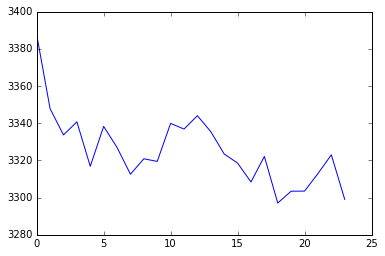

In [66]:
plt.plot(means)

In [56]:
kins=arr_list_stb2kins(arr_list_stb,cut_off)

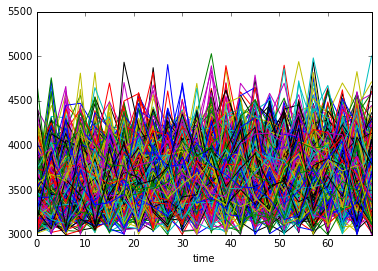

In [57]:
kins.plot(x="time",legend=False)

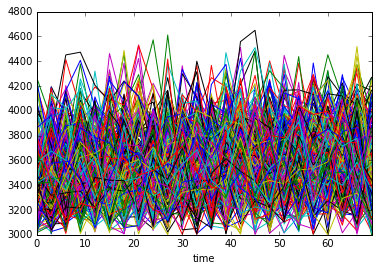

In [50]:
kins_mean.plot(x="time",legend=False)

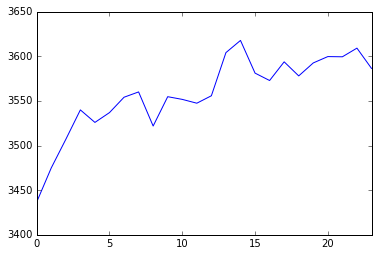

In [53]:
kins_mean.mean(axis=1).plot()

In [48]:
kins_mean=kins_mean.loc[:,kins_mean.std()<kins_mean.std().mean()]

In [49]:
kins_mean.shape

(24, 236)

In [ ]:
# data_num=pd.DataFrame(columns=wells)
# data_num.loc[:,'time']=time

if not exists("%s.data_num_kin" % (fh_xls)):
    data_num_kin=pd.DataFrame(columns=wells)
    data_num_kin.loc[:,'time']=time
    for well in wells:
        print ">>> STATUS  : nd2kins : %s" % well 
        nd_fns=data_fns[well].dropna().unique()
        well_kin=nd2kins(nd_fns,nd_dh,time_increment)
        if not pd.isnull(info_pt00s.loc[well])[0]:
            pt00=int(info_pt00s.loc[well])
            data_num_kin[well]=well_kin[pt00:pt00+12].values
        else :   
            data_num_kin[well]=well_kin[0:12].values
    data_num_kin.to_csv("%s.data_num_kin" % (fh_xls))
else:
    print ">>> STATUS  : data_num_kin :already done"
    data_num_kin=pd.read_csv("%s.data_num_kin" % (fh_xls))
data_num_kin2ana(data_num_kin,wells,wells_b,wells_u)
